# Object_detection
カスタム可能


Models:
https://developers.google.com/mediapipe/solutions/vision/object_detector/index#models

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [2]:
model_path = 'models/efficientdet.tflite'

In [3]:
MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

# Image

In [17]:
# download weight
# !wget -q -O models/efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite

In [3]:
# setting
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.ObjectDetectorOptions(base_options=base_options,
                                        score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

I0000 00:00:1711977174.111055       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [28]:
# load image
Image_file = './../../../../test_img/f3978ebc-9030-49e7-aa5e-4a370a955e1b.jpg'
image = mp.Image.create_from_file(Image_file)

In [29]:
# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

In [32]:
detection_result

DetectionResult(detections=[Detection(bounding_box=BoundingBox(origin_x=218, origin_y=9, width=694, height=1077), categories=[Category(index=None, score=0.88671875, display_name=None, category_name='cat')], keypoints=[])])

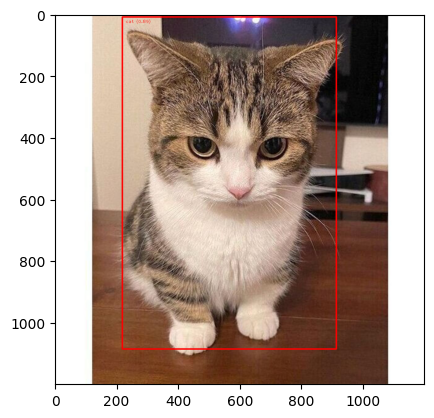

In [31]:
# visualize
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_annotated_image)
plt.show()

# Video

In [10]:
BaseOptions = mp.tasks.BaseOptions
ObjectDetector = mp.tasks.vision.ObjectDetector
ObjectDetectorOptions = mp.tasks.vision.ObjectDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode

options = ObjectDetectorOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    max_results=5,
    running_mode=VisionRunningMode.VIDEO)


In [11]:
# 動画読み込み
cap = cv2.VideoCapture('./../../../../test_video/2795691-hd_1920_1080_25fps.mp4')

In [12]:
# fps取得
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [13]:
output_vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

In [14]:
# フレームループ
with ObjectDetector.create_from_options(options) as detector:
    frame_index = 1
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            numpy_frame_from_opencv = np.asarray(frame)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)
            frame_timestamp_ms = int(1000 * frame_index / fps)
            detection_result = detector.detect_for_video(mp_image, frame_timestamp_ms)
            annotated_image = visualize(frame, detection_result)
            output_vid.write(annotated_image)
            
            frame_index += 1
        else:
            # VideoWriterを解放
            output_vid.release()
            break


I0000 00:00:1712126215.365505       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


# Live stream

クラッシュする、一時保留

# camera

image推論を連続使用

In [4]:
# setting
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.ObjectDetectorOptions(base_options=base_options,
                                        score_threshold=0.5)

In [6]:

with vision.ObjectDetector.create_from_options(options) as detector:
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        
        if ret:
            numpy_frame_from_opencv = np.asarray(frame)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)
            detection_result = detector.detect(mp_image)
            annotated_image = visualize(numpy_frame_from_opencv, detection_result)
            # rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
            
            cv2.imshow('camera' , frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    cv2.destroyAllWindows()